In [2]:
# Groupby 참고 : https://ponyozzang.tistory.com/291
# Random Forest의 부트 스트랩 : https://choice-life.tistory.com/62
# Random Forest 배깅 : 
# confusion_matrix 참고 : https://vincenthanna.tistory.com/entry/sklearn-confusion-matrix-%EC%98%88%EC%A0%9C
# classification_report 참고 : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

데이터 불러오기 및 처리

In [4]:
mem_data_path = '/content/drive/MyDrive/개인 연구/강의 수강/(패스트 캠퍼스) 데이터 분석/Ch6 Random Forest/member.csv'
tran_data_path = '/content/drive/MyDrive/개인 연구/강의 수강/(패스트 캠퍼스) 데이터 분석/Ch6 Random Forest/transaction.csv'

mem = pd.read_csv(mem_data_path)
tran = pd.read_csv(tran_data_path)

In [5]:
tran['avg_price'] = tran['total_amount']/tran['num_item']

In [6]:
# Groupby를 활용하여 id별 1줄로 데이터 요약
tran_mean = tran.groupby('id').mean()
# ID별 거래 건수 확인
tran_cnt = tran['id'].value_counts()

In [7]:
# concat으로 두 데이터 결합
tran_df = pd.concat([tran_mean, tran_cnt], axis = 1)

In [8]:
# Column 이름 변경
tran_df.columns = ['num_item', 'total_amount', 'avg_price', 'count']

In [9]:
# Join을 사용하기 위해, ID를 인덱스로 지정
mem.set_index('id', inplace=True)
# Join으로 데이터 합치기
data = mem.join(tran_df)

In [10]:
data = pd.get_dummies(data, columns=['zip_code', 'channel'], drop_first=True)

In [11]:
data

,recency,is_referral,conversion,num_item,total_amount,avg_price,count,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
id,,,,,,,,,,,
906145,10,0,0,3.333333,31333.333333,14016.666667,3,1,0,1,0
184478,6,1,0,4.000000,29000.000000,7250.000000,1,0,0,0,1
394235,7,1,0,4.000000,20500.000000,5125.000000,2,1,0,0,1
130152,9,1,0,1.750000,20750.000000,14875.000000,4,0,0,0,1
940352,2,0,0,3.000000,31000.000000,10333.333333,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
838295,10,0,0,3.500000,26000.000000,8012.500000,4,0,1,0,1
547316,5,1,0,1.800000,17800.000000,11300.000000,5,0,1,1,0
131575,6,1,0,4.000000,30500.000000,7833.333333,2,0,1,1,0


Random Forest Classifier 모델 구성 및 학습

In [12]:
# train, test 데이터 구성
X_train, X_test, y_train, y_test = train_test_split(data.drop('conversion', axis=1), data['conversion'], test_size=0.3, random_state=100)

In [13]:
model = RandomForestClassifier(max_depth=10, random_state=100)

In [14]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

Random Forest Classifier 모델 테스트

In [15]:
pred = model.predict(X_test)

In [16]:
accuracy_score(y_test, pred)

0.87515625

In [17]:
confusion_matrix(y_true=y_test, y_pred=pred)

array([[16403,    60],
       [ 2337,   400]])

In [18]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     16463
           1       0.87      0.15      0.25      2737

    accuracy                           0.88     19200
   macro avg       0.87      0.57      0.59     19200
weighted avg       0.87      0.88      0.83     19200



Random Forest Regressor 모델 구성 및 학습

In [19]:
regressor_model = RandomForestRegressor(max_depth=10, random_state=100)

In [20]:
regressor_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=100, verbose=0, warm_start=False)

In [21]:
pred = regressor_model.predict(X_test)

In [22]:
pd.DataFrame(pred)

,0
0,0.000000
1,0.058584
2,0.000000
3,0.594169
4,0.083316
...,...
19195,0.142431
19196,0.000000
19197,0.116323
19198,0.000000


In [23]:
# 확률 값을 class로 변환
result_comp = [1 if x>=0.5 else 0 for x in pred]

In [24]:
accuracy_score(y_test, result_comp)

0.8799479166666667

In [25]:
confusion_matrix(y_test, result_comp)

array([[16313,   150],
       [ 2155,   582]])

In [26]:
print(classification_report(y_test, result_comp))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     16463
           1       0.80      0.21      0.34      2737

    accuracy                           0.88     19200
   macro avg       0.84      0.60      0.63     19200
weighted avg       0.87      0.88      0.85     19200



파라미터 튜닝

In [31]:
# n_estimator 변경 : ensemble에 사용되는 모델의 개수
regressor_model = RandomForestRegressor(n_estimators=150, max_depth=12, random_state=100)
regressor_model.fit(X_train, y_train)
pred = regressor_model.predict(X_test)
result_comp = [1 if x>= 0.5 else 0 for x in pred]
accuracy_score(y_test, result_comp)

0.8800520833333333

In [32]:
# min_samples_leaf 변경 : leaf에 포함되는 최소한의 샘플 개수
regressor_model = RandomForestRegressor(max_depth=12, random_state=100, min_samples_leaf=5)
regressor_model.fit(X_train, y_train)
pred = regressor_model.predict(X_test)
result_comp = [1 if x>= 0.5 else 0 for x in pred]
accuracy_score(y_test, result_comp)

0.8810416666666666

변수 중요성 확인하기

In [28]:
regressor_model.feature_importances_

array([0.06762482, 0.02257451, 0.30347782, 0.16391703, 0.26407163,
       0.13794632, 0.00914256, 0.00957497, 0.01193737, 0.00973295])

In [29]:
X_train.columns

Index(['recency', 'is_referral', 'num_item', 'total_amount', 'avg_price',
       'count', 'zip_code_Surburban', 'zip_code_Urban', 'channel_Phone',
       'channel_Web'],
      dtype='object')

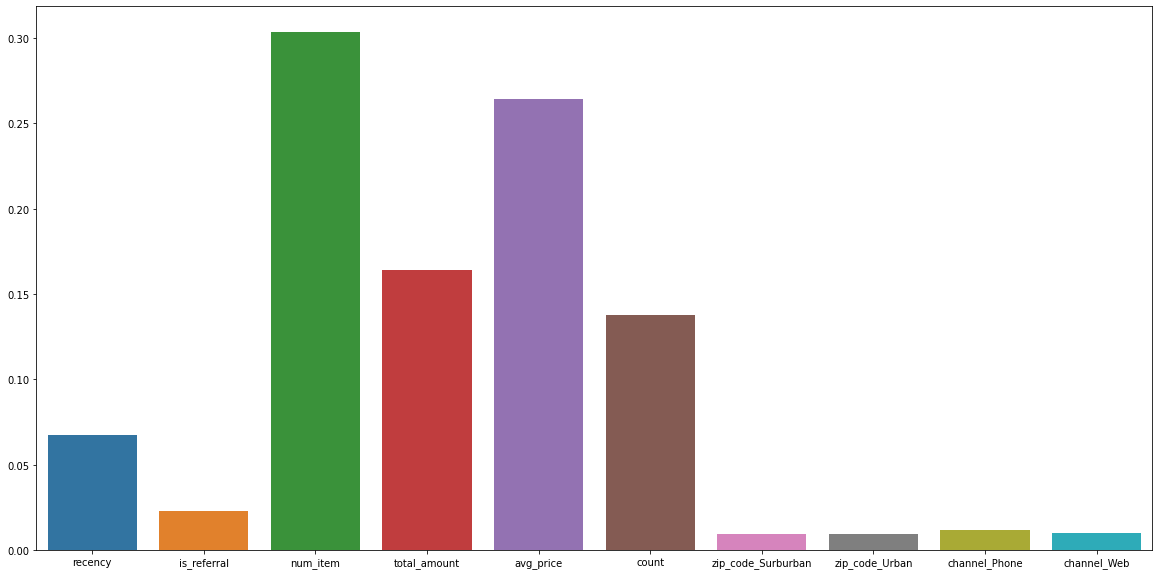

In [30]:
plt.figure(figsize=(20,10))
sns.barplot(x=X_train.columns, y=regressor_model.feature_importances_)